## Install packages and import libraries

In [ ]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense

from matplotlib import pyplot
import numpy as np
import pandas as pd
import seaborn as sns
import io
import tempfile
from keras.models import load_model

## Load data set

In [ ]:
url = 'http://www.cs.ndsu.nodak.edu/~siludwig/regressiondataset.csv'
raw_dataset = pd.read_csv(url,
 na_values='?', comment='\t',
 sep=',', skipinitialspace=True)

In [ ]:
dataset = raw_dataset.copy()
dataset = dataset.dropna()
train_dataset = dataset.sample(frac=0.85, random_state=0)
test_dataset = dataset.drop(train_dataset.index)
train_data = train_dataset.copy()
test_data = test_dataset.copy()
train_X = train_data.iloc[:,:-1]
test_X = test_data.iloc[:,:-1]
train_Y = train_data.iloc[:,-1:]
test_Y = test_data.iloc[:,-1:]

#Normalize data

In [ ]:
normalizer = tf.keras.layers.Normalization(axis=-1)

In [ ]:
normalizer.adapt(np.array(train_X))
print(normalizer.mean.numpy())

[[8.54791565e+01 6.11369400e+01 6.46662979e+01 4.18292427e+01
  1.39784408e+00 1.33534825e+00 1.46700104e+02 2.41042900e+01
  5.31001778e+01 5.16953239e+01 7.75787720e+02 9.58372681e+02
  7.29436035e+02 8.97891541e+02 1.54501724e+00 1.03010702e+00
  8.00688538e+02 6.04611084e+02 2.92081299e+02 3.25399384e+02
  1.61308990e+02 1.20666466e+02 1.41022690e+02 9.91362000e+01
  1.50645173e+00 1.41052365e+00 3.68324699e+01 6.73249130e+01
  7.15343475e+01 4.94707129e+03 3.49174390e+03 1.03686523e+03
  3.98796509e+02 1.24841416e+00 9.84236121e-01 9.92039160e+03
  2.03500867e+03 3.63913477e+03 3.79857935e+03 7.26312485e+01
  1.02154869e+02 4.45753593e+01 7.56496735e+01 1.27002323e+00
  8.45462203e-01 1.36980743e+02 6.99079666e+01 5.41810570e+01
  5.07435265e+01 8.39590549e+00 5.94213676e+00 4.44853592e+00
  2.38056159e+00 1.33180368e+00 1.15525639e+00 3.11193371e+00
  5.66478062e+00 5.56502724e+00 1.05928734e+02 9.50569916e+01
  1.20034790e+01 6.44965839e+00 7.06719697e-01 4.41082716e-01
  3.8956

In [ ]:
first = np.array(train_X[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[  76.52   57.09   59.31   35.87    1.2     0.95  122.91   36.1    44.29
    52.84  787.05 1011.5   734.22  940.22    1.31    0.78  772.    741.64
   314.51  353.88  151.75  104.24  131.3    84.06    1.28    1.13   49.15
    65.58   66.91 4434.36 2981.06  674.48   53.68    1.      0.75 8958.57
  1657.73 3402.86 3589.59   79.61  112.02   48.48   99.53    1.1     0.78
   135.97   81.33   54.37   42.08    6.91    3.83    3.48    1.04    1.09
     0.94    1.74    4.6     4.65  112.01   61.22    8.34    0.63    0.4
     0.27  399.97   57.13  166.74  138.47    2.27    2.21    2.23    1.37
     1.03    1.11    0.43    0.44]]

Normalized: [[-0.6  -0.26 -0.49 -0.41 -1.04 -1.82 -0.7   1.04 -0.71  0.1   0.23  0.5
   0.11  0.46 -1.21 -0.97 -0.56  0.73  0.78  0.66 -0.78 -0.76 -0.87 -0.63
  -1.15 -1.56  0.82 -0.21 -0.49 -0.55 -0.48 -0.92 -0.46 -1.1  -1.04 -0.48
  -0.57 -0.31 -0.46  0.55  0.66  0.24  1.14 -1.02 -0.39 -0.03  0.71  0.02
  -1.01 -0.43 -0.38 -0.79 -0.27 -1.   -1.05 -0.25 

#Plots, etc.

In [ ]:
def plot_loss(history):
  pyplot.plot(history.history['loss'], label='loss')
  pyplot.plot(history.history['val_loss'], label='val_loss')
  pyplot.ylim([100, 1000])
  pyplot.xlabel('Epoch')
  pyplot.ylabel('Error')
  pyplot.legend()
  pyplot.grid(True)

def scatter():
  a = pyplot.axes(aspect='equal')
  pyplot.scatter(test_Y, test_predictions)
  pyplot.xlabel('True Y vaules')
  pyplot.ylabel('Predicted Y values')
  lims = [-20,150]
  pyplot.xlim(lims)
  pyplot.ylim(lims)
  _ = pyplot.plot(lims, lims)

def histogram():
  error = test_predictions - test_Y
  pyplot.hist(error, bins=50)
  pyplot.xlabel('Prediction Error')
  _ = pyplot.ylabel('Count')



#Model looping and saving best model

###Model network build

In [ ]:
def simple_model(norm):
  model = keras.Sequential([
        norm,
        layers.Dense(64, activation='relu', input_dim = 76),
        layers.Dense(1)
        ])
  model.compile(loss='mean_squared_error',
                  optimizer=tf.keras.optimizers.Adam(0.001))
  return model

def deep_model(norm):
  model = keras.Sequential([
        norm,
        layers.Dense(64, activation='relu', input_dim = 76),
        layers.Dense(64),
        # layers.Dense(64),
        # layers.Dense(32),
        layers.Dense(1)
        ])
  model.compile(loss='mean_squared_error',
                  optimizer=tf.keras.optimizers.Adam(0.001))
  return model

def wide_model(norm):
  model = keras.Sequential([
      norm, 
      layers.Dense(128, activation='relu', input_dim = 76),
      # layers.Dense(128),
      layers.Dense(1)
  ])
  model.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.Adam(.001))
  return model



###Lists of experiments for the models 

In [ ]:
networks = [simple_model, deep_model, wide_model]
activations = ['relu','sigmoid']
optimizers = ['adam', 'adafactor', 'rmsprop']

##Run the experiments and save results

In [ ]:
test_results = {} # set of values for mse 

for network in networks:
    for optimizer in optimizers:
        for act in activations:
            # Create the model
            model = network(normalizer)

            history = model.fit(
                    train_X,
                    train_Y,
                    validation_split=0.2,
                    verbose=0,
                    epochs=100)
            
            # Evaluate the model
            
            test_results[network.__name__, optimizer, act] = model.evaluate(
                  train_X, 
                  train_Y,
                  verbose=0
              )
            test_results


##Table of MSE for configurations

In [ ]:
pd.DataFrame(test_results, index=['Mean Squared Error']).T

Mean Squared Error
simple_model adam      relu             252.898376
                       sigmoid          250.194122
             adafactor relu             249.432297
                       sigmoid          250.505966
             rmsprop   relu             246.605621
                       sigmoid          254.615829
deep_model   adam      relu             224.150848
                       sigmoid          205.449539
             adafactor relu             201.596756
                       sigmoid          213.984909
             rmsprop   relu             221.605072
                       sigmoid          213.852951
wide_model   adam      relu             228.052185
                       sigmoid          228.773254
             adafactor relu             223.645050
                       sigmoid          226.008575
             rmsprop   relu             223.847076
                       sigmoid          229.893326

##Printout of best configuration

In [ ]:
min_val = min(test_results.values())
min_vals = [key for key in test_results if test_results[key]==min_val]
val_list =[item for i in min_vals for item in i]
print('The best configuration model:\n Network structure: ', val_list[0], '\n Optimizer: ', val_list[1], '\n Activation: ', val_list[2])

The best configuration model:
 Network structure:  deep_model 
 Optimizer:  adafactor 
 Activation:  relu


#Run history with best model and plot 

In [ ]:
network = eval(val_list[0])
for network in networks:
    for val_list[1] in optimizers:
        for val_list[2] in activations:
            # Create the model
            best_model = network(normalizer)



In [ ]:
best_history = best_model.fit(
    train_X,
    train_Y,
    validation_split=0.2,
    verbose=0, 
    epochs=100)

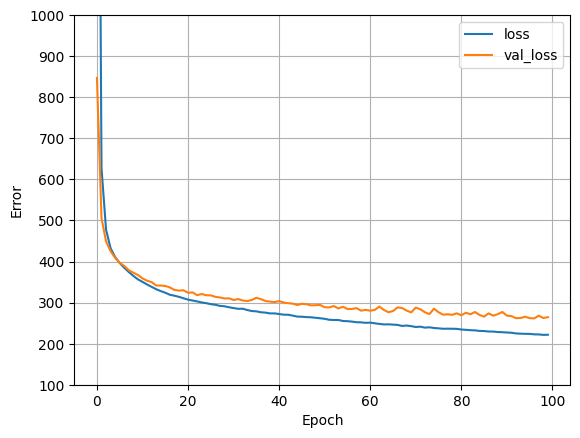

In [ ]:
plot_loss(best_history)

47/47 [==============================] - 0s 905us/step


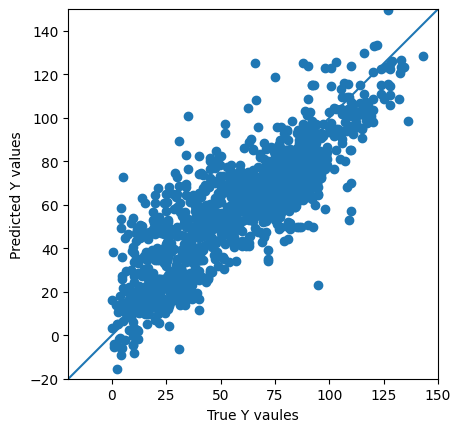

In [ ]:
test_predictions = best_model.predict(test_X).flatten()

scatter()


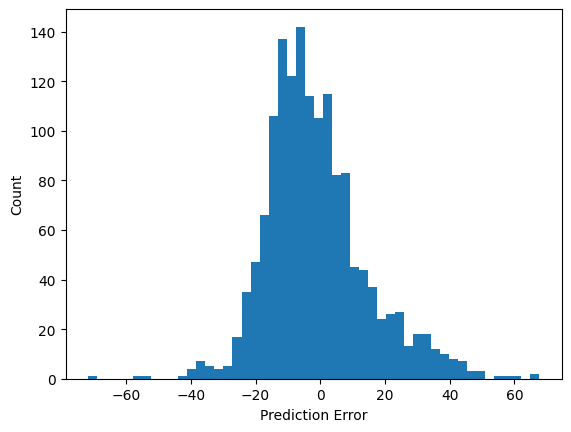

In [ ]:
count_tp_number = len(test_predictions)
test_predictions=test_predictions.reshape(count_tp_number,1)

histogram()